In [92]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D, LSTM
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
movie_reviews = pd.read_csv('/content/drive/MyDrive/XLNNTN/TH/07/IMDB Dataset.csv')

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [95]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [96]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

<Axes: xlabel='sentiment', ylabel='count'>

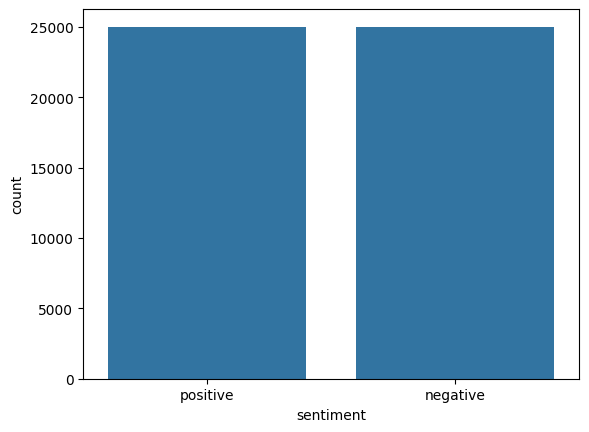

In [97]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [98]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [99]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [100]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [101]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [102]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [104]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [105]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [106]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/XLNNTN/TH/07/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [107]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#Text Classification with Simple Neural Network

In [131]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [132]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          9254700   
                                                                 
 flatten_4 (Flatten)         (None, 10000)             0         
                                                                 
 dense_7 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 9264701 (35.34 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9254700 (35.30 MB)
_________________________________________________________________
None


In [133]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 7ms/step - loss: 0.6095 - acc: 0.6674 - val_loss: 0.5498 - val_acc: 0.7193
Epoch 2/6
250/250 [==============================] - 1s 6ms/step - loss: 0.5050 - acc: 0.7544 - val_loss: 0.5444 - val_acc: 0.7214
Epoch 3/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4626 - acc: 0.7804 - val_loss: 0.5211 - val_acc: 0.7481
Epoch 4/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4451 - acc: 0.7932 - val_loss: 0.5736 - val_acc: 0.7197
Epoch 5/6
250/250 [==============================] - 2s 9ms/step - loss: 0.4228 - acc: 0.8078 - val_loss: 0.5253 - val_acc: 0.7460
Epoch 6/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4142 - acc: 0.8113 - val_loss: 0.5299 - val_acc: 0.7491


In [134]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5314 - acc: 0.7418


In [135]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5314238667488098
Test Accuracy: 0.7418000102043152


In [136]:
import matplotlib.pyplot as plt

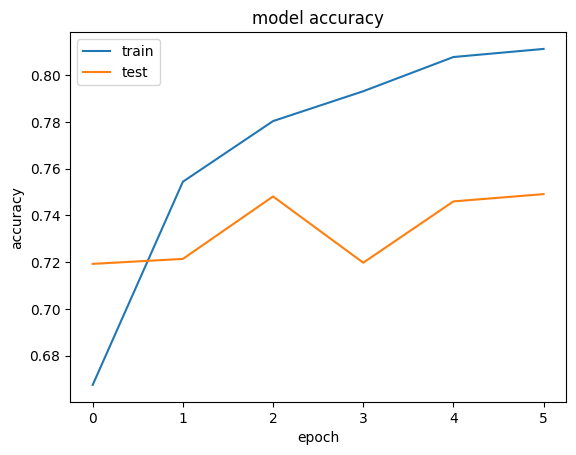

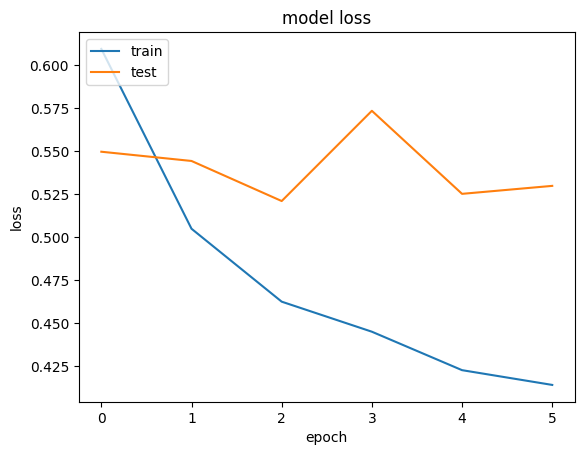

In [137]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#Text Classification with a Convolutional Neural Network

In [116]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [117]:
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          9254700   
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9318957 (35.55 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9254700 (35.30 MB)
_________________________________________________________________
None


In [118]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 25s 98ms/step - loss: 0.5031 - acc: 0.7495 - val_loss: 0.3969 - val_acc: 0.8229
Epoch 2/6
250/250 [==============================] - 23s 93ms/step - loss: 0.3704 - acc: 0.8356 - val_loss: 0.3903 - val_acc: 0.8202
Epoch 3/6
250/250 [==============================] - 26s 102ms/step - loss: 0.3198 - acc: 0.8653 - val_loss: 0.3519 - val_acc: 0.8421
Epoch 4/6
250/250 [==============================] - 23s 93ms/step - loss: 0.2879 - acc: 0.8803 - val_loss: 0.3468 - val_acc: 0.8432
Epoch 5/6
250/250 [==============================] - 25s 101ms/step - loss: 0.2476 - acc: 0.9038 - val_loss: 0.3542 - val_acc: 0.8420
Epoch 6/6
313/313 [==============================] - 3s 10ms/step - loss: 0.3750 - acc: 0.8318


In [119]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.37503474950790405
Test Accuracy: 0.8317999839782715


In [120]:
score

[0.37503474950790405, 0.8317999839782715]

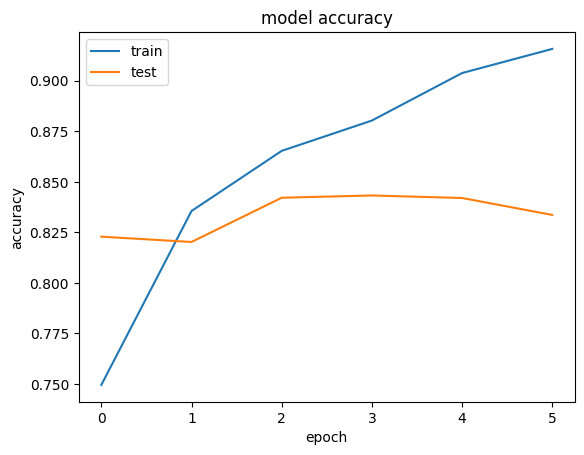

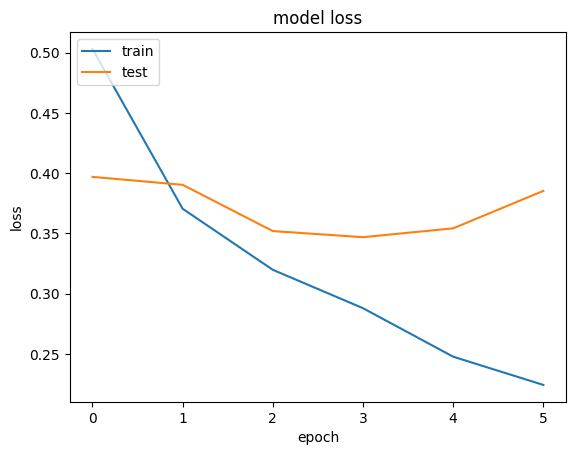

In [121]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

#Text Classification with Recurrent Neural Network (LSTM)

In [122]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [123]:
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 100)          9254700   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9372077 (35.75 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9254700 (35.30 MB)
_________________________________________________________________
None


In [124]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 82s 318ms/step - loss: 0.5395 - acc: 0.7244 - val_loss: 0.4460 - val_acc: 0.7889
Epoch 2/6
250/250 [==============================] - 77s 308ms/step - loss: 0.4448 - acc: 0.7927 - val_loss: 0.4168 - val_acc: 0.8202
Epoch 3/6
250/250 [==============================] - 78s 313ms/step - loss: 0.3919 - acc: 0.8238 - val_loss: 0.3688 - val_acc: 0.8388
Epoch 4/6
250/250 [==============================] - 79s 317ms/step - loss: 0.3658 - acc: 0.8347 - val_loss: 0.3531 - val_acc: 0.8481
Epoch 5/6
250/250 [==============================] - 76s 306ms/step - loss: 0.3479 - acc: 0.8461 - val_loss: 0.3581 - val_acc: 0.8440
Epoch 6/6
313/313 [==============================] - 17s 55ms/step - loss: 0.3392 - acc: 0.8471


In [125]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.339203804731369
Test Accuracy: 0.847100019454956


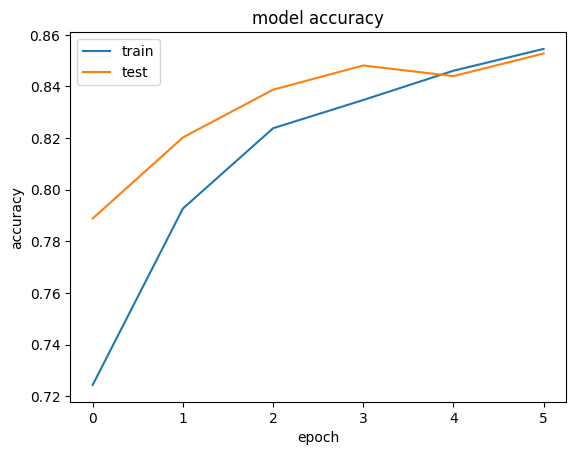

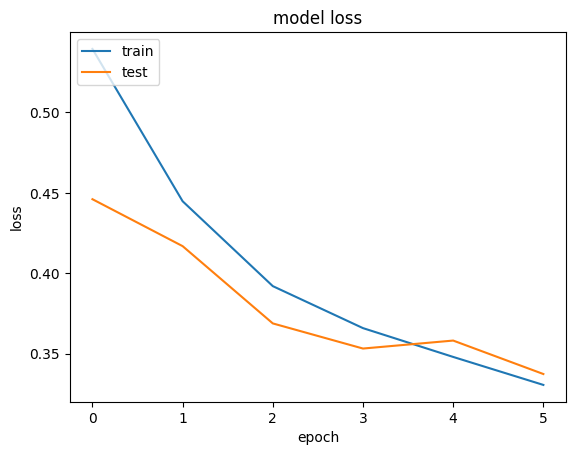

In [126]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [127]:
instance = X[57]
print(instance)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 


In [128]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

1/1 [==============================] - 0s 494ms/step


array([[0.82267445]], dtype=float32)